<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-выбросы" data-toc-modified-id="Проверка-на-выбросы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка на выбросы</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разбиение-данных-на-обучающую,-валидационную-и-тестовую-выборки" data-toc-modified-id="Разбиение-данных-на-обучающую,-валидационную-и-тестовую-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разбиение данных на обучающую, валидационную и тестовую выборки</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузка основных моделуй

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Загрузка дополнительных модулей (графики и т.п.)

In [2]:
import matplotlib.pyplot as plt #Графики
from tqdm.notebook import tqdm #Полоса прогресса

Загрузка моделей

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor 

Загрузка датасета

In [4]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
df=df.sort_index() 
print(df.index.is_monotonic) # проверка сортировки
df_season = df.copy()

True


## Анализ

### Проверка на выбросы

Смотрим инфо

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверяем пропуски и дубликаты

In [7]:
df.isna().sum(), df.duplicated().sum()

(num_orders    0
 dtype: int64,
 26415)

Проверка на аномалии и выбросы

In [8]:
df['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

Мы видим большие значение (119 вызовов!). Чтобы стало яснее взглянем на график.

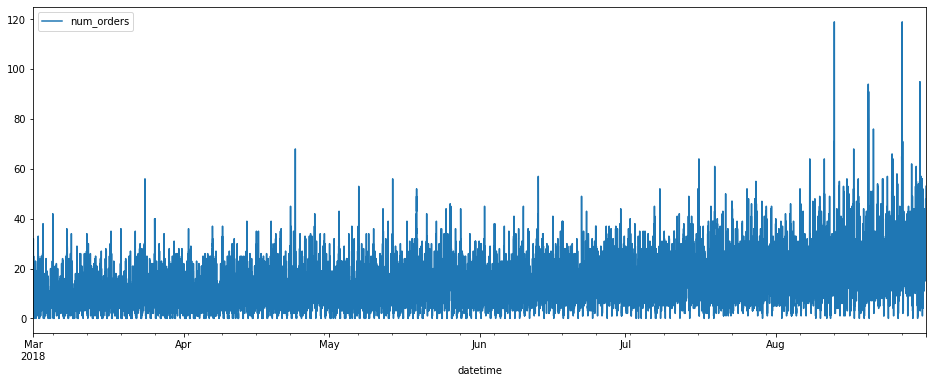

In [9]:
figsize = (16, 6)
df.plot(figsize = figsize);

Мы видим некоторое количество выбросов в августе. Однако, сначала проведём ресемплирование по одному часу, а затем посмотрим, будут ли выбросы мешать анализу.

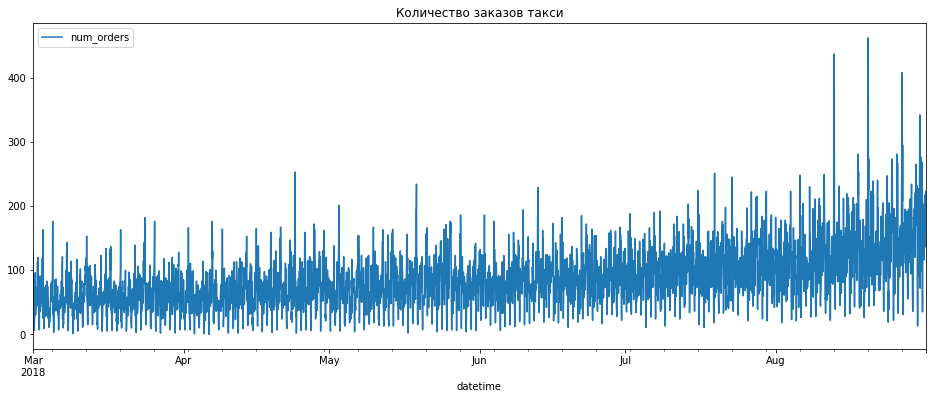

In [10]:
df=df.resample('1H').sum()
plt.figure(figsize=(16, 6))
plt.title("Количество заказов такси")
df.plot(ax=plt.gca());

Мы видим пиковые значения в августе. Такое в принципе возможно, так как по условию задачи рассматривается вызов такси к аэропорту, летом возможны подобные перегрузки. Основная задача именно предсказывать подобные пиковые значения, чтобы выделить больше такси, потому не убираем выбросы.

### Анализ данных

Скользящее среднее

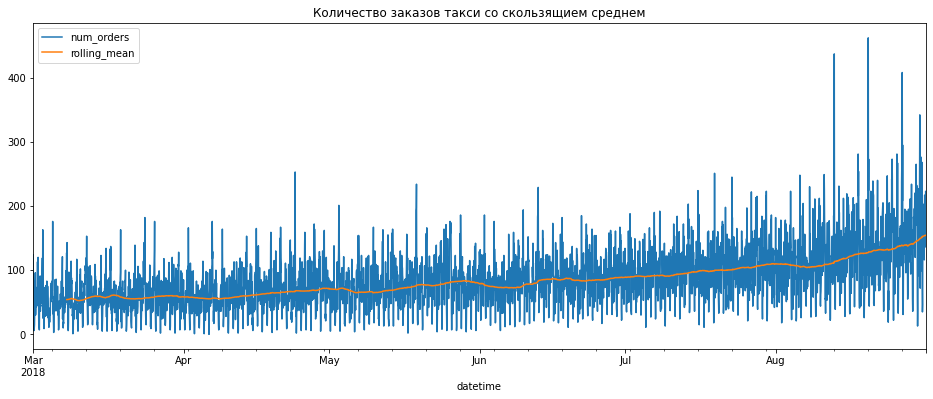

In [11]:
df['rolling_mean'] = df.rolling(24*7).mean()
plt.figure(figsize=(16,6))
plt.title("Количество заказов такси со скользящием среднем")
df.plot(ax=plt.gca());

Смотрим тренд, сезонность и остаток

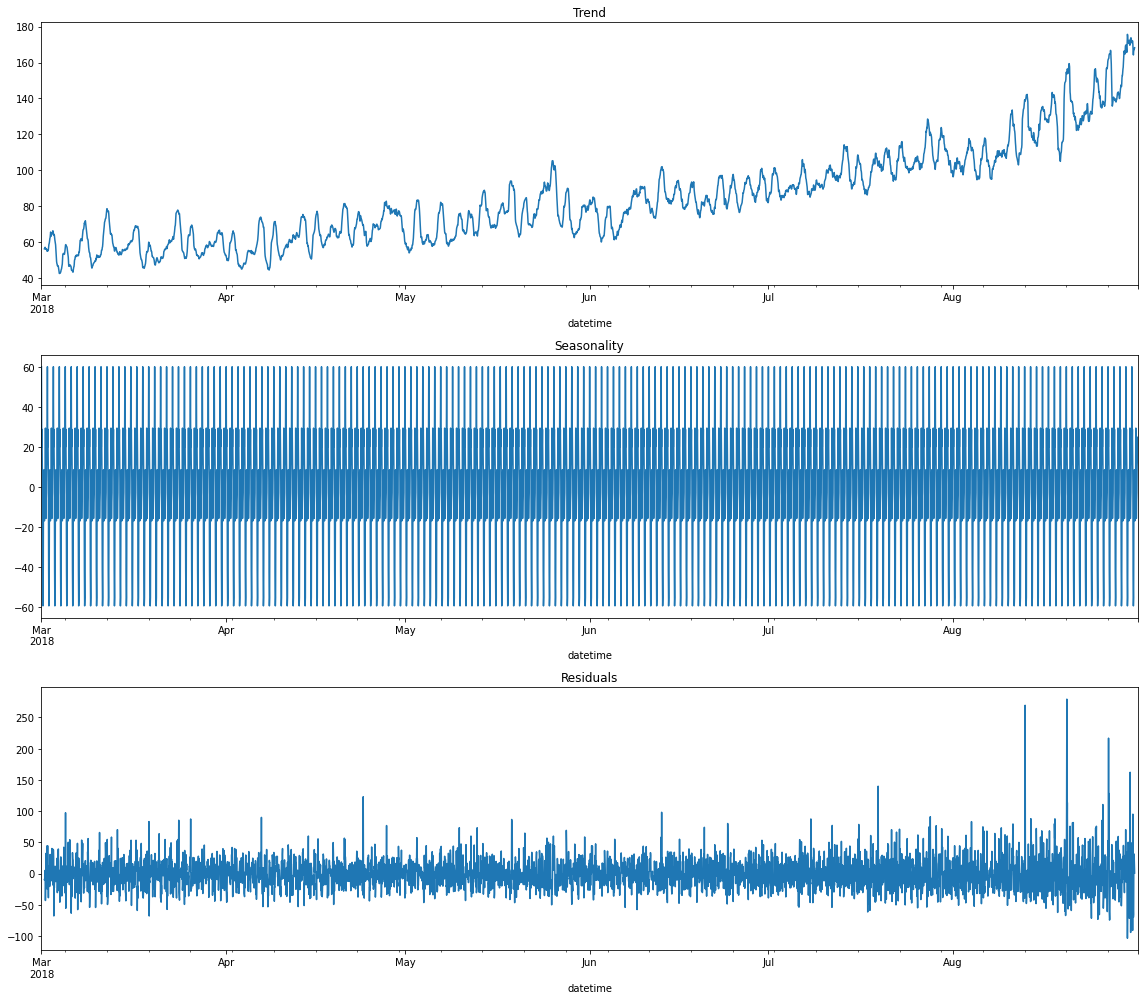

In [12]:
decomposed = seasonal_decompose(df.drop(['rolling_mean'], axis = 1))

plt.figure(figsize=(16, 14))
plt.subplot(311)

ax=plt.gca()
decomposed.trend.plot(ax=plt.gca()) # тренд
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) # сезонная составляющая
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) # остатки
plt.title('Residuals')
plt.tight_layout()

Мы наблюдаем тренд на увеличение количества заказов в течении года. Однако, график сезонности ничего нам не говорит, потому посмотрим на сезонность подробней. 

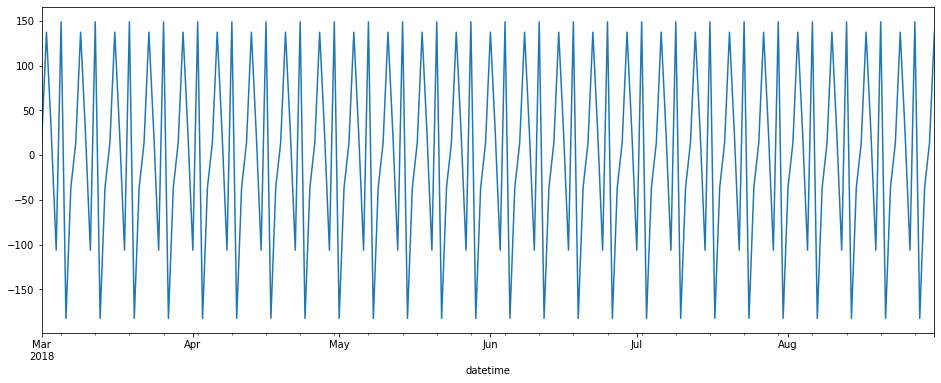

In [13]:
df_season=df_season.resample('1D').sum()
plt.figure(figsize=(16, 6))

decomposed2 = seasonal_decompose(df_season)
decomposed2.seasonal.plot(ax=plt.gca());

Посмотрим в течении августа

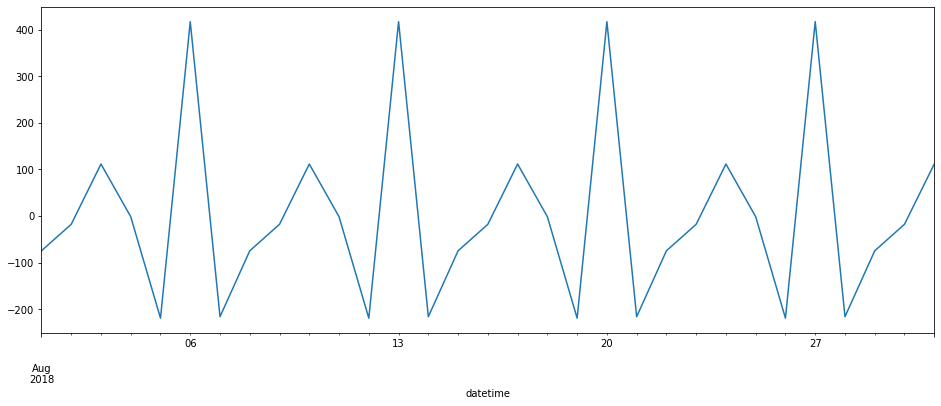

In [14]:
df_season = df_season['2018-08-01':'2018-08-31']
plt.figure(figsize=(16, 6))

decomposed2 = seasonal_decompose(df_season)
decomposed2.seasonal.plot(ax=plt.gca());

Мы видим, что сезонность скачет в зависимости от дня недели. Посмотрим на медиану количества заказов по дням недели.

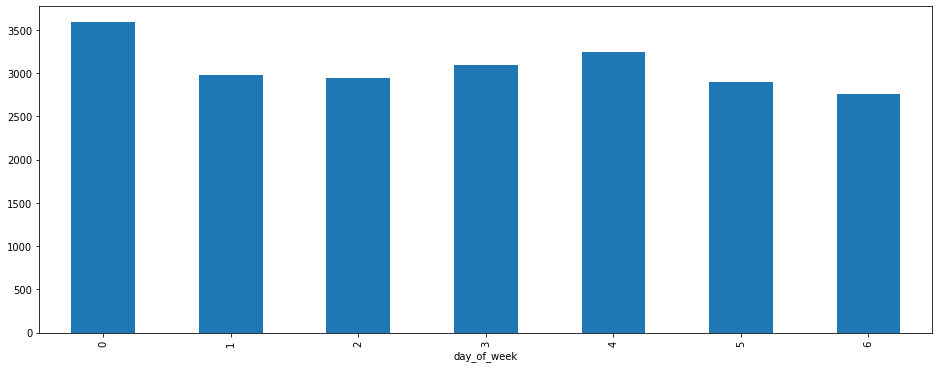

In [15]:
df_season['day_of_week'] = df_season.index.weekday
df_season.groupby(by='day_of_week').median()['num_orders'].plot(kind='bar', figsize = (16,6));

Мы видим, что больше всего заказов в понедельник и пятницу, меньше в выходные. Посмотрим сезонность посуточно для первой недели августа.

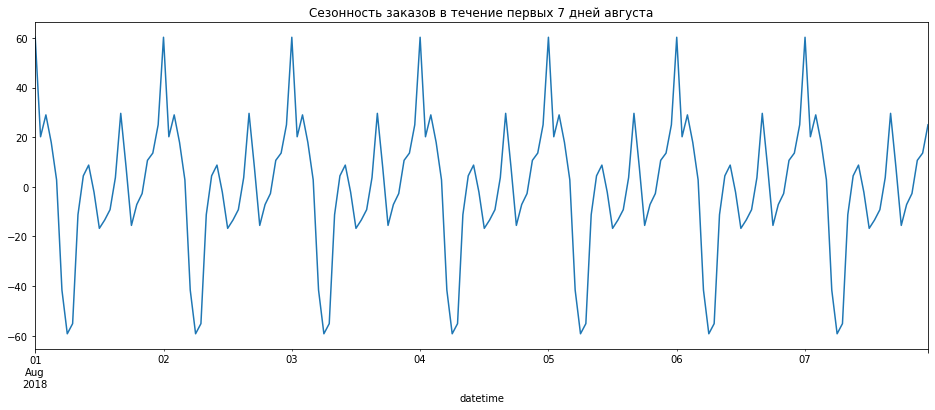

In [16]:
plt.figure(figsize=(16,6))
plt.title("Сезонность заказов в течение первых 7 дней августа")
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca());

Мы видим, что количество заказов зависит от времени суток. Посмотрем подробней.

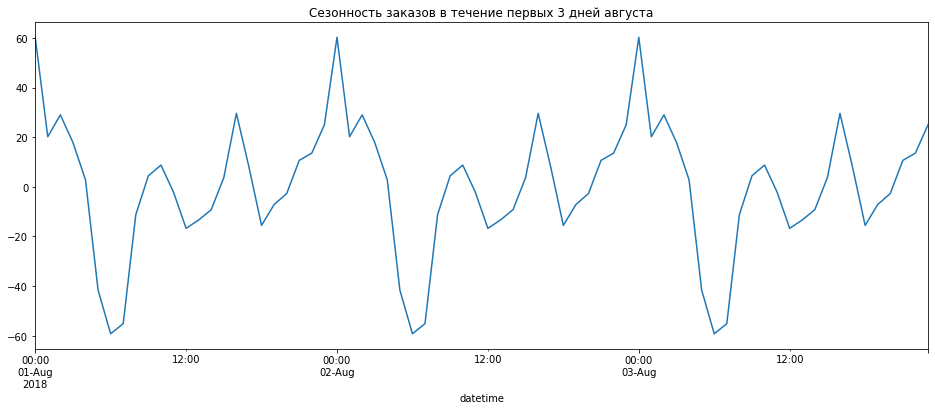

In [17]:
plt.figure(figsize=(16,6))
plt.title("Сезонность заказов в течение первых 3 дней августа")
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=plt.gca());

Мы видим, что пик заказов в полночь, а подутро заказов намного меньше.

### Вывод

Количество заказов растёт в течении года, очевидно летом оно наивысшее. Про осень ничего нельзя сказать, так как данных на осень нет. Также мы выявили зависимость количества заказов от времени суток и от дня недели.

## Обучение

Для начала, нам нужно создать признаки. Кроме того, помимо гиперпараметров может оказаться полезным рассмотреть разные варианты смещения. Для этого напишем функцию.

### Разбиение данных на обучающую, валидационную и тестовую выборки

In [18]:
df = df.drop(['rolling_mean'], axis = 1)

In [19]:
def make_features(max_lag, rolling_mean_size):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [20]:
def prepare(max_lag = 1, rolling_mean_size = 7):
    data = make_features(max_lag, rolling_mean_size)
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    train = train.dropna() #избавляемся от созданных нами пропусков
    
    global X_train, y_train, X_test, y_test

    

    
    X_train = train.drop(['num_orders'], axis=1)
    y_train = train['num_orders'] 
    
    
    X_test = test.drop(['num_orders'], axis=1)
    y_test= test['num_orders']
    
    

Смысл был в том, что помимо гиперпараметров можно подбирать и смещение, таким образом, добиться лучшего качества работы модели. Мы не будем делать это для всех моделей, подберём для лучшей.


Проверяем, что функция работает корректно

In [21]:
prepare(11)
len(X_train), len(X_test), len(df)
X_train

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 11:00:00,2018,3,1,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,34.714286
2018-03-01 12:00:00,2018,3,1,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,42.285714
2018-03-01 13:00:00,2018,3,1,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,45.714286
2018-03-01 14:00:00,2018,3,1,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,48.571429
2018-03-01 15:00:00,2018,3,1,3,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,53.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,2018,8,13,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,118.0,146.714286
2018-08-13 10:00:00,2018,8,13,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,103.857143
2018-08-13 11:00:00,2018,8,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,102.142857


Функция для нашего скорера

In [22]:
def rmse_score (y, X):
    rmse = mean_squared_error(y, X)**0.5
    return rmse

Функция для кросс-валидации

In [23]:
def best_model(model, parameters, vebrose = 0):

    scorer = make_scorer(rmse_score, greater_is_better=False)
    tscv = TimeSeriesSplit(n_splits=5)
    model_grid = GridSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=vebrose, n_jobs=-1)
    model_grid.fit(X_train, y_train)
    return model_grid.best_score_, model_grid.best_params_

In [24]:
models = []

### Обучение моделей

#### Линейная регрессия

In [25]:

parameters = {'fit_intercept':[False], 'normalize':[True]}

best_rmse = 0
lag = 0
rolling_mean_size = 0

for i in tqdm(range(1,29, 1)):
    for i2 in range(5,22,4):
        prepare(i,i2)
        rmse, bmodel = best_model(LinearRegression(), parameters)
        rmse = abs(rmse)
    if rmse < best_rmse or best_rmse == 0:
        best_rmse = rmse
        lag = i
        rolling_mean_size = i2
        best_params = bmodel
        
mod_list = [bmodel, lag, rolling_mean_size, best_rmse]
models.append(mod_list)
models

  0%|          | 0/28 [00:00<?, ?it/s]

[[{'fit_intercept': False, 'normalize': True}, 24, 21, 27.020277865562935]]

#### Дерево решений

In [26]:


max_depth_list = [x for x in range(21, 30,4)]
parameters = [{ 
                'max_depth':max_depth_list, 
                'min_samples_leaf': [5,10,15],
                'random_state':[42]}]


best_rmse = 0
lag = 0
rolling_mean_size = 0

for i in tqdm(range(1,25, 5)):
    for i2 in range(8,22,7):
        prepare(i,i2)
        rmse, bmodel = best_model(DecisionTreeRegressor(random_state=42), parameters)
        rmse = abs(rmse)
    if rmse < best_rmse or best_rmse == 0:
        best_rmse = rmse
        lag = i
        rolling_mean_size = i2
        best_params = bmodel
        
mod_list = [bmodel, lag, rolling_mean_size, best_rmse]
models.append(mod_list)
models

  0%|          | 0/5 [00:00<?, ?it/s]

[[{'fit_intercept': False, 'normalize': True}, 24, 21, 27.020277865562935],
 [{'max_depth': 21, 'min_samples_leaf': 15, 'random_state': 42},
  21,
  15,
  33.418162575474135]]

#### Случайный лес

In [27]:


max_depth_list = [x for x in range(21, 30,4)]
parameters = {'n_estimators': range(20, 100, 20), 'max_depth': range(10, 20, 5)}


best_rmse = 0
lag = 0
rolling_mean_size = 0

for i in tqdm(range(1,25, 5)):
    for i2 in range(8,22,7):
        prepare(i,i2)
        rmse, bmodel = best_model(RandomForestRegressor(random_state=42), parameters)
        rmse = abs(rmse)
    if rmse < best_rmse or best_rmse == 0:
        best_rmse = rmse
        lag = i
        rolling_mean_size = i2
        best_params = bmodel
        
mod_list = [bmodel, lag, rolling_mean_size, best_rmse]
models.append(mod_list)
models

  0%|          | 0/5 [00:00<?, ?it/s]

[[{'fit_intercept': False, 'normalize': True}, 24, 21, 27.020277865562935],
 [{'max_depth': 21, 'min_samples_leaf': 15, 'random_state': 42},
  21,
  15,
  33.418162575474135],
 [{'max_depth': 15, 'n_estimators': 80}, 21, 15, 28.4048249122737]]

#### CatBoostRegressor

In [28]:
%%time

parameters = {'depth': range(5, 16, 4), 'iterations': range(18, 22, 3), 'verbose':[0]}

best_rmse = 0
lag = 0
rolling_mean_size = 0

for i in tqdm(range(21,22, 5)):
    for i2 in range(16,22,7):
        prepare(i,i2)
        rmse, bmodel = best_model(CatBoostRegressor(random_state=42), parameters)
        rmse = abs(rmse)
    if rmse < best_rmse or best_rmse == 0:
        best_rmse = rmse
        lag = i
        rolling_mean_size = i2
        best_params = bmodel
        
mod_list = [bmodel, lag, rolling_mean_size, best_rmse]
models.append(mod_list)
models

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1min 9s, sys: 640 ms, total: 1min 9s
Wall time: 1min 38s


[[{'fit_intercept': False, 'normalize': True}, 24, 21, 27.020277865562935],
 [{'max_depth': 21, 'min_samples_leaf': 15, 'random_state': 42},
  21,
  15,
  33.418162575474135],
 [{'max_depth': 15, 'n_estimators': 80}, 21, 15, 28.4048249122737],
 [{'depth': 5, 'iterations': 21, 'verbose': 0}, 21, 16, 29.369053701730348]]

## Тестирование

Посмотрим на предварительные результаты

In [29]:
final = pd.DataFrame(data=models, index=['Linear Regression', 'DecisionTreeRegressor', 'RandomForestRegressor',
                                         'CatBoost'], 
                     columns=['Лучшие параметры', 'lag', 'rolling mean size', 'RMSE'])
final

,Лучшие параметры,lag,rolling mean size,RMSE
Linear Regression,"{'fit_intercept': False, 'normalize': True}",24,21,27.020278
DecisionTreeRegressor,"{'max_depth': 21, 'min_samples_leaf': 15, 'ran...",21,15,33.418163
RandomForestRegressor,"{'max_depth': 15, 'n_estimators': 80}",21,15,28.404825
CatBoost,"{'depth': 5, 'iterations': 21, 'verbose': 0}",21,16,29.369054


Так как мы помимо гиперпараметров меняли параметры lag и rolling mean size, напишем функцию, которая сможет протестировать данные с учётом этих парамтров.

In [30]:
def testing(model):
    params = models[model][ 0]
    lag = models[model][1]
    rms = models[model][2]
    prepare(lag, rms)
    model_selection = [LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor]
    
    mymodel = model_selection[model](**params)
    mymodel.fit(X_train, y_train)
    predictions = mymodel.predict(X_test)
    
    rmse = mean_squared_error(y_test, predictions)**0.5

    plt.figure(figsize=(18,8))
    plt.title('Сравнение реальных значений и предсказанных')

    plt.plot(y_test.index, predictions, 'r', label='Предсказания')
    plt.plot(y_test.index, y_test.values, 'g', label='Реальные значения')
    plt.legend(loc="upper left")
    plt.grid(True)
    
    print('RMSE модели: ', rmse)
    return rmse

В кроссвалидации лучше всего себя показала линейная регрессия. Проверяем на тестовых данных.

RMSE модели:  45.52933708020873


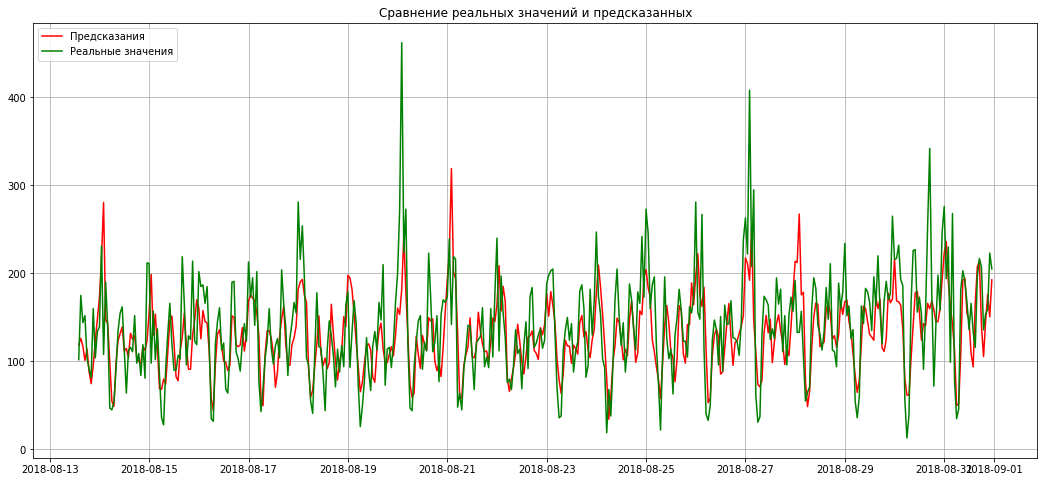

In [31]:
rmse = testing(0)

In [32]:
if rmse < 48:
    print('RMSE = ', rmse, ' что меньше 48, что требовалось по условию задачи.')
else:
    print('RMSE = ', rmse, ' что больше 48, не удалось достичь необходимого результата.')

RMSE =  45.52933708020873  что меньше 48, что требовалось по условию задачи.


In [33]:
prepare(24, 21)

In [34]:
#Лучшей на валидационной выборке показала себя линейная регрессия. Проверяем на тестовой выборке:
model = LinearRegression(fit_intercept = False, normalize = True)
model.fit(X_train, y_train)
pred = model.predict(X_test)
rmse = mean_squared_error(y_test, pred)**0.5
print(rmse)

45.52933708020873


rmse ~ 45.6, что меньше 48.

## Вывод

Был проведён анализ данных. На стадии предобработки данных не было выявлено критических проблем (пропуски и т.п.).
Мы выснили, что тренд растёт к концу года, так же количество вызовов зависит от времени суток и дня недели.

Были проверенны несколько моделей. Использовался метод кросс-валидации. Помимо перебора гиперпараметров, использовался перебор таких параметров как временной сдвиг (lag) и rolling mean size. Эти параметры также влияют на качество обучения моделей.

Для корректной кросс-валидации использовался модуль TimeSeriesSplit. В результате был получен RMSE < 48 (по условию задачи RMSE должен быть меньше либо равен 48).